# ShapRFECV - Recursive Feature Elimination using SHAP importance

[![open in colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/ing-bank/probatus/blob/master/docs/tutorials/nb_shap_feature_elimination.ipynb)

Recursive Feature Elimination allows to efficiently reduce the number of features in your dataset, without losing the predictive power of the model. `probatus` implements the following feature elimination routine for **tree-based models**:


    While any features left, iterate:
        1. (Optional) Tune hyperparameters, in case `GridSearchCV` or `RandomSearchCV` are provided as estimators,
        2. Calculate SHAP feature importance using Cross-Validation,
        3. Remove `step` lowest importance features.


The functionality is similar to [RFECV](https://scikit-learn.org/stable/modules/generated/sklearn.feature_selection.RFECV.html), yet, it removes the lowest importance features, based on SHAP features importance. It also supports the use of [GridSearchCV](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html) and [RandomizedSearchCV](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.RandomizedSearchCV.html) passed as a `clf`, thanks to which you can perform hyperparameter optimization at each step of the search.
hyperparameters of the model at each round, to tune the model for each features set. Lastly, it supports categorical features (`object` and `category` dtype) and missing values in the data, as long as the model supports them.
 
The main advantages of using this routine are:

- It uses a tree-based model to detect the complex relations between features and the target.
- It uses SHAP importance, which is one of the most reliable ways to estimate features importance. Unlike many other techniques, it works with missing values and categorical variables.
- Supports the use of [GridSearchCV](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html) and [RandomizedSearchCV](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.RandomizedSearchCV.html) in order to optimize hyperparameters at each iteration. This way you can assess if the removal of a given feature reduces the predictive power, or simply requires additional tuning of the model.
- You can also provide a list of features, that should not be eliminated. E.g incase of prior knowledge.

The disadvantages are:

- Removing lowest [SHAP](https://shap.readthedocs.io/en/latest/) importance feature does not always translate to choosing the feature with lowest impact on model's performance. Shap importance illustrates how strongly a given feature affects the output of the model, while disregarding correctness of this prediction.
- Currently, the functionality only supports tree-based binary classifiers, in the future the scope might be extended.

## Setup the dataset

In order to use the functionality, let's set up an example dataset with:

- 17 numerical features
- 1 categorical feature
- 1 static feature
- 1 static feature
- 1 feature with missing values

In [16]:
from probatus.feature_elimination import ShapRFECV
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
import numpy as np
import pandas as pd
import lightgbm
from sklearn.model_selection import RandomizedSearchCV
 
feature_names = ['f1_categorical', 'f2_missing', 'f3_static', 'f4', 'f5', 'f6', 'f7', 'f8', 'f9', 'f10', 'f11', 'f12', 'f13', 'f14', 'f15', 'f16', 'f17', 'f18', 'f19', 'f20']
 
# Prepare two samples
X, y = make_classification(n_samples=1000, class_sep=0.05, n_informative=6, n_features=20,
                           random_state=0, n_redundant=10, n_clusters_per_class=1)
X = pd.DataFrame(X, columns=feature_names)
X['f1_categorical'] = X['f1_categorical'].apply(lambda x: str(np.round(x*10)))
X['f2_missing'] = X['f2_missing'].apply(lambda x: x if np.random.rand()<0.8 else np.nan)
X['f3_static'] = 0

In [17]:
#First 5 rows of first 5 columns
X[feature_names[:5]].head()

,f1_categorical,f2_missing,f3_static,f4,f5
0,34.0,-3.902230,0,0.037207,-0.211075
1,-25.0,0.772855,0,0.302824,0.729950
2,-7.0,1.350847,0,1.837895,-0.745689
3,-53.0,4.559465,0,-1.277930,3.688404
4,-10.0,NaN,0,-0.576209,-0.790525


## Set up the model and model tuning

You need to set up the model that you would like to use in the feature elimination. `probatus` requires a **tree-based binary classifier** in order to speed up the computation of SHAP feature importance at each step. 
We recommend using [LGBMClassifier](https://lightgbm.readthedocs.io/en/latest/pythonapi/lightgbm.LGBMClassifier.html), which by default handles missing values and categorical features.

The example below applies randomized search in order to optimize the hyperparameters of the model at each iteration of the search.

In [18]:
clf = lightgbm.LGBMClassifier(max_depth=5, class_weight='balanced')

param_grid = {
    'n_estimators': [5, 7, 10],
    'num_leaves': [3, 5, 7, 10],
}
search = RandomizedSearchCV(clf, param_grid)


## Apply ShapRFECV

Now let's apply the [ShapRFECV](https://ing-bank.github.io/probatus/api/feature_elimination.html).

In [19]:
shap_elimination = ShapRFECV(
    clf=search, step=0.2, cv=10, scoring='roc_auc', n_jobs=3)
report = shap_elimination.fit_compute(X, y)

At the end of the process, you can investigate the results for each iteration.

In [20]:
#First 5 rows of first 5 columns
report[['num_features', 'features_set', 'val_metric_mean']]

,num_features,features_set,val_metric_mean
1,20,"[f1_categorical, f2_missing, f3_static, f4, f5...",0.905
2,16,"[f19, f9, f15, f3_static, f8, f11, f20, f18, f...",0.905
3,13,"[f19, f9, f15, f8, f11, f20, f18, f16, f10, f1...",0.905
4,11,"[f10, f19, f1_categorical, f12, f9, f15, f8, f...",0.893
5,9,"[f19, f1_categorical, f9, f15, f8, f20, f14, f...",0.901
6,8,"[f19, f1_categorical, f9, f15, f8, f14, f16, f5]",0.910
7,7,"[f19, f1_categorical, f9, f15, f14, f16, f5]",0.901
8,6,"[f19, f1_categorical, f9, f15, f14, f16]",0.901
9,5,"[f19, f1_categorical, f9, f15, f16]",0.883
10,4,"[f19, f1_categorical, f16, f9]",0.868


Once the process is completed, you can visualize the results. 

Let's investigate the performance plot. In this case, the Validation AUC score has a peak at 11 features.

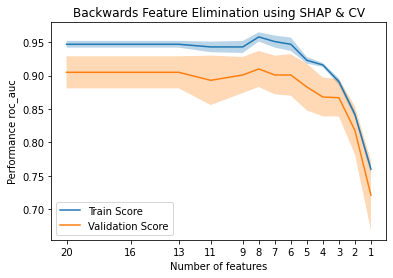

In [21]:
performance_plot = shap_elimination.plot()

Let's see the final feature set:

In [22]:
shap_elimination.get_reduced_features_set(num_features=11)

['f10',
 'f19',
 'f1_categorical',
 'f12',
 'f9',
 'f15',
 'f8',
 'f20',
 'f14',
 'f16',
 'f5']

You can also provide a list of features that sholud not be eliminated. 
Say based on your prior knowledge you know that features `f10,f19,f15` are important and sholud not be eliminated.
This can be done by providing a list of columns to columns_to_keep parameter in the fit function.


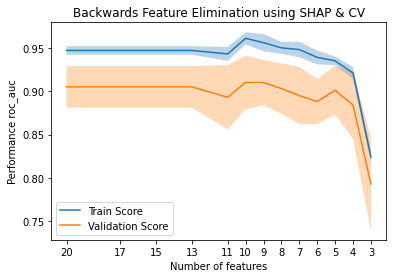

In [23]:
shap_elimination = ShapRFECV(
    clf=search, step=0.2, cv=10, scoring='roc_auc', n_jobs=3)
report = shap_elimination.fit_compute(X, y,columns_to_keep=['f10','f15','f19'])

performance_plot = shap_elimination.plot()


Let's see the final feature set:

In [24]:
shap_elimination.get_reduced_features_set(num_features=3)

['f10', 'f19', 'f15']

## ShapRFECV vs RFECV

In this section we will compare the performance of the model trained on the features selected using the probatus [ShapRFECV](https://ing-bank.github.io/probatus/api/feature_elimination.html) and the [sklearn RFECV](https://scikit-learn.org/stable/modules/generated/sklearn.feature_selection.RFECV.html).

In order to compare them let's first prepare a dataset, and a model that will be applied:

In [13]:
from probatus.feature_elimination import ShapRFECV
import numpy as np
import pandas as pd
import lightgbm
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.feature_selection import RFECV
import matplotlib.pyplot as plt

# Prepare train and test data:
X, y = make_classification(n_samples=10000, class_sep=0.1, n_informative=40, n_features=50,
                           random_state=0, n_clusters_per_class=10)
X = pd.DataFrame(X)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5, random_state=42)

# Set up the model:
clf = lightgbm.LGBMClassifier(n_estimators=10, num_leaves=7)

Now, we can run ShapRFECV and RFECV with the same parameters, to extract the optimal feature sets:

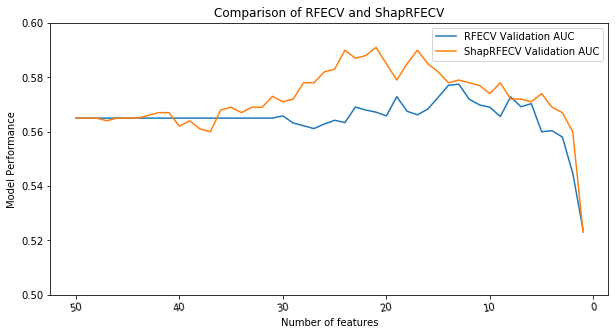

In [15]:
# Run RFECV and ShapRFECV with the same parameters
rfe = RFECV(clf, step=1, cv=10, scoring='roc_auc', n_jobs=3).fit(X_train, y_train)
shap_elimination = ShapRFECV(clf=clf, step=1, cv=10, scoring='roc_auc', n_jobs=3)
shap_report = shap_elimination.fit_compute(X_train, y_train)

# Compare the CV Validation AUC for different number of features in each method.
ax = pd.DataFrame({'RFECV Validation AUC': list(reversed(rfe.grid_scores_)),
                   'ShapRFECV Validation AUC': shap_report['val_metric_mean'].values.tolist()}, 
                 index=shap_report['num_features'].values.tolist()).plot(ylim=(0.5, 0.6), rot=10, title='Comparison of RFECV and ShapRFECV', figsize=(10,5))
ax.set_ylabel("Model Performance")
ax.set_xlabel("Number of features")
ax.invert_xaxis()
plt.show()

The plot above presents the averaged CV Validation AUC of model performance for each round of the RFE process in both ShapRFECV and RFECV. The optimal number of features is 21 for the former, and 13 for the latter.

Now we will compare the performance of the model trained on:

- All 50 available features (baseline),
- 13 features selected by RFECV (final),
- 21 features selected by ShapRFECV (final),
- 13 feature selected by ShapRFECV (baseline).

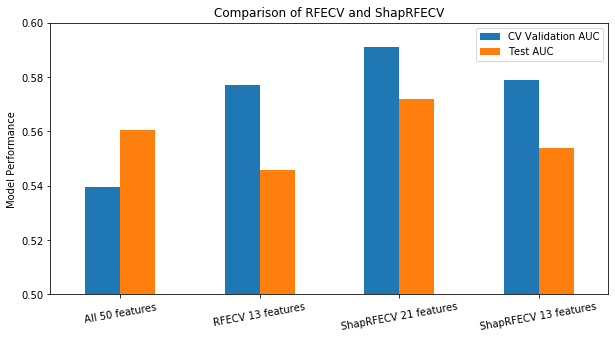

In [17]:
n_features_shap = 21
n_features_rfecv = rfe.n_features_

# Calculate the AUC for the models with different feature sets
test_auc_full = clf.fit(X_train, y_train).score(X_test, y_test)
val_auc_full =  np.mean(cross_val_score(clf, X_train, y_train, cv=10))

rfe_features_set = X_train.columns[rfe.support_]
test_auc_rfe = clf.fit(X_train[rfe_features_set], y_train).score(X_test[rfe_features_set], y_test)
val_auc_rfe = rfe.grid_scores_[n_features_rfecv]

shap_feature_set = X_train.columns[shap_elimination.get_reduced_features_set(n_features_shap)]
test_auc_shap = clf.fit(X_train[shap_feature_set], y_train).score(X_test[shap_feature_set], y_test)
val_auc_shap = shap_report[shap_report.num_features == n_features_shap]['val_metric_mean'].values[0]

shap_feature_set_size_rfe = X_train.columns[shap_elimination.get_reduced_features_set(n_features_rfecv)]
test_auc_shap_size_rfe = clf.fit(X_train[shap_feature_set_size_rfe], y_train).score(X_test[shap_feature_set_size_rfe], y_test)
val_auc_shap_size_rfe = shap_report[shap_report.num_features == n_features_rfecv]['val_metric_mean'].values[0]

# Plot Test and Validation Performance
variants = ('All 50 features', f'RFECV {n_features_rfecv} features', f'ShapRFECV {n_features_shap} features', f'ShapRFECV {n_features_rfecv} features')
results_test = [test_auc_full, test_auc_rfe, test_auc_shap, test_auc_shap_size_rfe]
results_val = [val_auc_full, val_auc_rfe, val_auc_shap, val_auc_shap_size_rfe]

ax = pd.DataFrame({'CV Validation AUC': results_val,
                   'Test AUC': results_test}, index=variants).plot.bar(ylim=(0.5, 0.60), rot=10, title='Comparison of RFECV and ShapRFECV', figsize=(10,5))
ax.set_ylabel("Model Performance")
plt.show()

As shown in the plot, ShapRFECV provides superior results for both: CV Validation and Test AUC, compared to RFECV and the baseline model with all the available features. Not only the introduced method allows to eliminate features without the loss in performance, but also it may increase the performance of the model.

When it comes to time required to perform the feature selection in the experiment above, RFECV takes 6.11 s ± 33.7 ms, while ShapRFECV takes 10.1 s ± 72.8 mss, which shows that the latter is more computation expensive, due to SHAP values calculation.